<a href="https://colab.research.google.com/github/yuvi-2-3/ec507/blob/main/Copy_of_Untitled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import StandardScaler, LabelEncoder

from scipy import stats
from statsmodels.stats.contingency_tables import mcnemar


print('Libraries imported')

Libraries imported


#Data Description
For classification model I am using other data set This dataset is about students’ performance in two Portuguese high schools. It contains information like:

Student's grades (marks)

*Student's grades (marks)
*Demographic details (age, gender, etc.)  
*Social information (parent's jobs, family background, etc.)

*School-related features (study time, absences, etc.)

There are two separate datasets — one for Maths and one for the Portuguese language subjects.

I am used this data to predict students’ final grades (G3), as a regression task (predicting the exact score) or a classification task (predicting whether a student passes/fails or their grade category).

Source = https://archive.ics.uci.edu/dataset/320/student+performance


In [14]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
student_performance = fetch_ucirepo(id=320)

# data (as pandas dataframes)
X = student_performance.data.features
y = student_performance.data.targets

# metadata
print(student_performance.metadata)

# variable information
print(student_performance.variables)

{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'ID': 360, 'type': 'NATIVE', 'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'venue': 'Proceedings of 5th Annual Future Business Technolo

In [15]:
pip install ucimlrepo

In [16]:
#Combine your imported data
df = pd.concat([X, y], axis=1)


# Create binary target column (Pass = 1, Fail = 0)
df['pass_fail'] = df['G3'].apply(lambda x: 1 if x >= 10 else 0)

# Prepare features and target
X_clf = df.drop(columns=['G1', 'G2', 'G3', 'pass_fail'])
y_clf = df['pass_fail']

# Encode categorical features
cat_cols = X_clf.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    X_clf[col] = le.fit_transform(X_clf[col])

X_clf = X_clf.values
y_clf = y_clf.values

Running all the regression

In [17]:
# Define classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=200, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores = {name: [] for name in classifiers}

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_clf, y_clf)):
    Xtr, Xte = X_clf[train_idx], X_clf[test_idx]
    ytr, yte = y_clf[train_idx], y_clf[test_idx]

    scaler = StandardScaler().fit(Xtr)
    Xtr_s = scaler.transform(Xtr)
    Xte_s = scaler.transform(Xte)

    print(f"\nProcessing Fold {fold_idx+1}/5 ...")
    for name, model in classifiers.items():
        Xtr_use = Xtr_s if name in ('LogisticRegression', 'SVM') else Xtr
        Xte_use = Xte_s if name in ('LogisticRegression', 'SVM') else Xte

        model.fit(Xtr_use, ytr)
        preds = model.predict(Xte_use)
        acc = accuracy_score(yte, preds)
        acc_scores[name].append(acc)


# Results summary
acc_df = pd.DataFrame(acc_scores)
acc_df.index = [f'Fold_{i+1}' for i in range(acc_df.shape[0])]

print("\n Model Mean Accuracies (higher is better):")
print(acc_df.mean().sort_values(ascending=False))



Processing Fold 1/5 ...

Processing Fold 2/5 ...

Processing Fold 3/5 ...

Processing Fold 4/5 ...

Processing Fold 5/5 ...

 Model Mean Accuracies (higher is better):
RandomForest          0.852069
SVM                   0.850531
LogisticRegression    0.850519
DecisionTree          0.802767
dtype: float64


Since i have run all the regression  and obtained the root mean square and the regression model used is decision tree since it's root mean square value is lowest .

T-test

In [18]:
# Paired t-tests between classifiers

from scipy import stats

clf_names = list(acc_scores.keys())
ttest_clf = []

for i in range(len(clf_names)):
    for j in range(i + 1, len(clf_names)):
        a = np.array(acc_scores[clf_names[i]])
        b = np.array(acc_scores[clf_names[j]])
        # Compare accuracies across folds (paired samples)
        tstat, pval = stats.ttest_rel(a, b)
        ttest_clf.append({
            'clf_a': clf_names[i],
            'clf_b': clf_names[j],
            't_stat': tstat,
            'p_value': pval,
            'mean_diff (a-b)': a.mean() - b.mean()
        })

# Create dataframe for results
tt_clf_df = pd.DataFrame(ttest_clf).sort_values('p_value')

print("\n🔍 Classification Paired t-test Results (sorted by p-value):")
print(tt_clf_df)


🔍 Classification Paired t-test Results (sorted by p-value):
                clf_a         clf_b    t_stat   p_value  mean_diff (a-b)
4        DecisionTree           SVM -3.751754  0.019917        -0.047764
0  LogisticRegression  DecisionTree  3.399068  0.027301         0.047752
3        DecisionTree  RandomForest -3.262999  0.030993        -0.049302
1  LogisticRegression  RandomForest -0.303634  0.776545        -0.001550
5        RandomForest           SVM  0.272166  0.798966         0.001538
2  LogisticRegression           SVM -0.001733  0.998701        -0.000012




1. Between DecisionTree and SVM , the mean difference is negitive and even the p vlaue is less than .05 so DecisionTree is better.  
2. Between LogisticRegression and DecisionTree , the mean difference is positive and the p-value is less than .05 so we reject the null hypothesis and DecisionTree is better.

3. Between DecisionTree and RandomForest , the mean difference is negitive and the p value is less than
.05 so we reject the null hypothesis and DecisionTree is better   
4. In rest all the cases the p value is greater than
  .05 so we fail to reject the null hypothesis.





/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


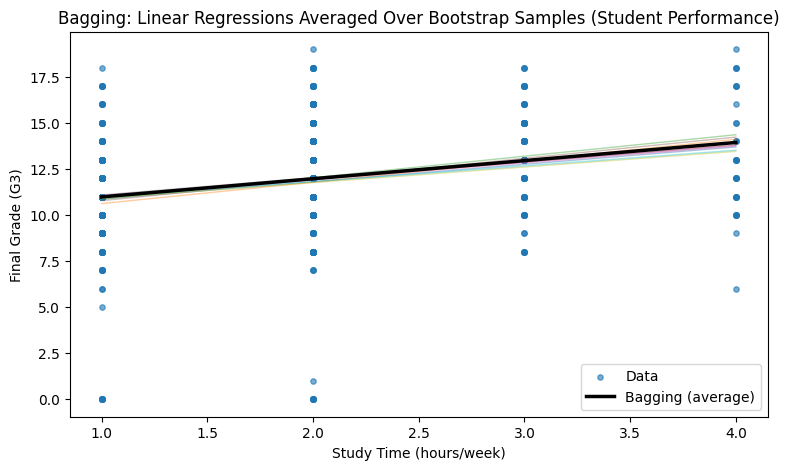

In [19]:

from sklearn.ensemble import BaggingRegressor
X = df[['studytime']]  # independent variable
y = df['G3']           # dependent variable (final grade)

# Build Bagging model using Linear Regression as base estimator
bagging_model = BaggingRegressor(
    estimator=LinearRegression(),
    n_estimators=100,
    bootstrap=True,
    random_state=0
)

# Fit the model
bagging_model.fit(X, y)

# Create a smooth X range for predictions
xx = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)

# Plot data and model predictions
plt.figure(figsize=(9,5))
plt.scatter(X, y, s=15, alpha=0.6, label='Data')

# Plot first 10 individual regressors
for est in bagging_model.estimators_[:10]:
    plt.plot(xx, est.predict(xx), alpha=0.4, linewidth=1)

# Plot averaged Bagging prediction
plt.plot(xx, bagging_model.predict(xx), color='black', linewidth=2.5, label='Bagging (average)')

plt.title("Bagging: Linear Regressions Averaged Over Bootstrap Samples (Student Performance)")
plt.xlabel("Study Time (hours/week)")
plt.ylabel("Final Grade (G3)")
plt.legend()
plt.show()

As the graph shows as study time increases the grades increases but the slope is not that steep and as i have used bagging it has help me reduce varience because it has used as can be shown in figure many regression line as compared to one in linear regression .   

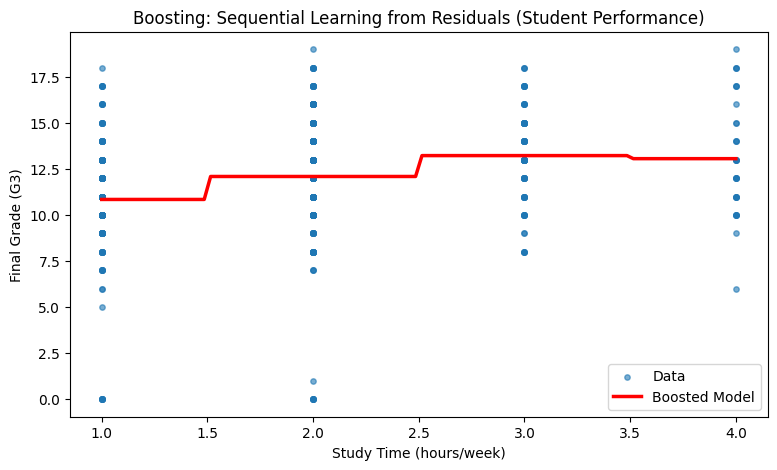

In [20]:

# Boosting on Student Performance Dataset

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
data = df.copy()

# Encode categorical variables
label_encoder = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    data[col] = label_encoder.fit_transform(data[col])

# Select relevant feature (Study time) and target (Final grade G3)
X = data[['studytime']].values   # independent variable
y = data['G3'].values            # dependent variable

# For smooth curve plotting, create a sequence of study time values
xx = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

# Define and train Gradient Boosting model
boost_model = GradientBoostingRegressor(
    learning_rate=0.2,
    n_estimators=100,
    max_depth=1,       # shallow trees (decision stumps)
    random_state=0
)
boost_model.fit(X, y)

#  Plot Boosting results
plt.figure(figsize=(9, 5))
plt.scatter(X, y, s=15, alpha=0.6, label="Data")
plt.plot(xx, boost_model.predict(xx), color='red', linewidth=2.5, label="Boosted Model")

plt.title("Boosting: Sequential Learning from Residuals (Student Performance)")
plt.xlabel("Study Time (hours/week)")
plt.ylabel("Final Grade (G3)")
plt.legend()
plt.show()

There is a stepwise increasing trend in the graph and it shows that as study time increases final grade increases.The red line keeps adjusting stage by stage trying to reduce those leftover errors.The final red line is the sum of many small models , that is why there is flat plateaus with sudden jumps.